- (c) Ken-ichi Fukui, 2025/01/06
- MIT License

## 線形回帰によるHousingデータ住宅価格の推定

In [1]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_selection import SequentialFeatureSelector
import matplotlib.pyplot as plt

### California Housingデータのロード

In [2]:
housing = fetch_california_housing()
X = scale(housing.data)
y = housing.target

print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

### データを分割
- sub1は特徴選択やハイパーパラメータ最適化用データ，sub2は最適化後の評価用データ

In [3]:
X_sub1, X_sub2, y_sub1, y_sub2 = train_test_split(X, y, test_size = 0.5, random_state = 0)

### 線形回帰＋逐次前進特徴選択（SBS）

In [5]:
r2_trn_ave, r2_tst_ave = [], []

for n_features in range(1, 8):
    lr = LinearRegression()
    sfs_forward = SequentialFeatureSelector(lr,
                                            scoring = 'r2',
                                            direction='forward',
                                            n_features_to_select=n_features,
                                            cv=5)
    sfs_forward.fit(X_sub1, y_sub1)
    print("Selected feature names:", sfs_forward.get_feature_names_out(housing.feature_names))

    X_sub2_selected = sfs_forward.transform(X_sub2)
    lr_selected = LinearRegression()
    scores = cross_validate(lr_selected, X_sub2_selected, y_sub2, cv=10, return_train_score=True)
    r2_trn_ave.append(scores['train_score'].mean())
    r2_tst_ave.append(scores['test_score'].mean())

Selected feature names: ['MedInc']
Selected feature names: ['MedInc' 'HouseAge']
Selected feature names: ['MedInc' 'HouseAge' 'Latitude']
Selected feature names: ['MedInc' 'HouseAge' 'Latitude' 'Longitude']
Selected feature names: ['MedInc' 'HouseAge' 'AveRooms' 'Latitude' 'Longitude']
Selected feature names: ['MedInc' 'HouseAge' 'AveRooms' 'Population' 'Latitude' 'Longitude']
Selected feature names: ['MedInc' 'HouseAge' 'AveRooms' 'AveBedrms' 'Population' 'Latitude'
 'Longitude']


### 特徴数毎の平均決定係数のグラフをプロット

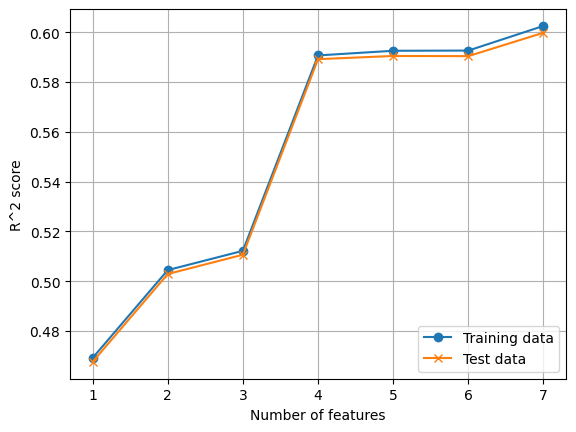

In [6]:
plt.plot(range(1,8), r2_trn_ave, marker='o', label="Training data")
plt.plot(range(1,8), r2_tst_ave, marker='x', label="Test data")
plt.ylabel('R^2 score')
plt.xlabel('Number of features')
plt.legend(loc="lower right")
plt.grid()
plt.show()

### Lasso回帰

In [22]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

# グリッドサーチによりハイパーパラメータを探索
params = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1.0]}
gs = GridSearchCV(Lasso(), params, cv=10, scoring="r2")
gs.fit(X_sub1, y_sub1)
print("best validation score: {:.3f}, best param: {}".format(gs.best_score_, gs.best_params_))

best validation score: 0.593, best param: {'alpha': 0.01}


### ベストパラメータで再学習し選択された特徴名を表示

In [24]:
lasso_best = Lasso(alpha=gs.best_params_['alpha'])
lasso_best.fit(X_sub1, y_sub1)
selector = SelectFromModel(estimator=lasso_best, prefit=True)
print(selector.get_support())
selected_features = np.array(housing.feature_names)[selector.get_support()]
print("Selected features:", selected_features)

[ True  True  True  True False  True  True  True]
Selected features: ['MedInc' 'HouseAge' 'AveRooms' 'AveBedrms' 'AveOccup' 'Latitude'
 'Longitude']


### クロスバリデーションによる評価

In [25]:
scores = cross_validate(lasso_best, X_sub2, y_sub2, cv=10, return_train_score=True)
print('Training r2: {:.3f}'.format(scores['train_score'].mean()))
print('Test r2: {:.3f}'.format(scores['test_score'].mean()))

Training r2: 0.600
Test r2: 0.597


### SVR

In [29]:
from sklearn.svm import SVR

params = {'gamma':[0.01, 0.1, 1.0, 10.0]}
gs = GridSearchCV(SVR(kernel='rbf'), params, cv=10, scoring="r2")
gs.fit(X_sub1, y_sub1)
print("best validation score: {:.3f}, best param: {}".format(gs.best_score_, gs.best_params_))

best validation score: 0.741, best param: {'gamma': 1.0}


### ベストパラメータに対してクロスバリデーションにより評価



In [28]:
svr_best = SVR(kernel='rbf', gamma=gs.best_params_['gamma'])
scores = cross_validate(svr_best, X_sub2, y_sub2, cv=10, return_train_score=True)
print('Training r2: {:.3f}'.format(scores['train_score'].mean()))
print('Test r2: {:.3f}'.format(scores['test_score'].mean()))

Training r2: 0.812
Test r2: 0.741
